In [1]:
#import matplotlib.pyplot as plt
#import numpy as np
#import sys
#sys.path.append('..')
#import tensorflow as tf
#from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
#from tqdm import tqdm
#
#from odcd.models.autoencoder import VAE
#from odcd.od.vae import OutlierVAE
#from odcd.utils.visualize import plot_instance_outlier, plot_feature_outlier_image
#from odcd.utils.perturbation import apply_mask

import tensorflow as tf
# https://github.com/tensorflow/tensorflow/issues/24828
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

#tf.debugging.set_log_device_placement(True)

#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import sys
sys.path.append('..')

from odcd.models.autoencoder import VAE
from odcd.od.vae import OutlierVAE
from odcd.utils.visualize import plot_instance_outlier, plot_feature_outlier_image
from odcd.utils.perturbation import apply_mask

import warnings
warnings.filterwarnings('ignore')

## Define model

In [2]:
latent_dim = 1024

encode_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
  ])

decode_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(latent_dim,)),
      Dense(4*4*128),
      Reshape(target_shape=(4, 4, 128)),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

vae = VAE(encode_net, decode_net, latent_dim, beta=1.)

## Load model weights

Need to recursively load `encoder`, `decoder` and then the `vae` model

In [3]:
encode_net.load_weights('./modelenc/enccifar10.ckpt')
decode_net.load_weights('./modeldec/deccifar10.ckpt')
vae = VAE(encode_net, decode_net, latent_dim, beta=1.)
vae.load_weights('./modelvae/vaecifar10.ckpt')

## Load model

In [ ]:
#test = pickle.load(open(save_dir + 'OutlierVAE.pickle','rb'))
#print(test)
encode_net = tf.keras.models.load_model(model_dir + 'encoder_net.h5')
decode_net = tf.keras.models.load_model(model_dir + 'decoder_net.h5')
vae = VAE(encode_net, decode_net, latent_dim, beta=beta)
vae.load_weights(model_dir + 'vae.ckpt')

## Initialize outlier detector

In [4]:
od = OutlierVAE(threshold=.015,
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                vae=vae,
                samples=2,
                data_type='image')

## Load CIFAR100 data

In [5]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, type(X_train), type(y_train))

(50000, 32, 32, 3) (50000, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Check model

In [6]:
idx = 8
X = X_train[idx].reshape(1, 32, 32, 3)
X_recon = od.vae(X)

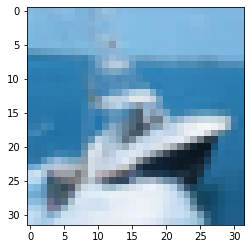

In [7]:
plt.imshow(X.reshape(32, 32, 3))

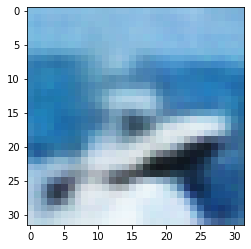

In [8]:
plt.imshow(X_recon.numpy().reshape(32, 32, 3))

## Check outliers on original CIFAR images

In [9]:
X = X_train[:500]
print(X.shape)

(500, 32, 32, 3)


In [10]:
od_preds = od.predict(X,
                      outlier_type='instance',
                      return_feature_score=True,
                      return_instance_score=True)
print(od_preds['meta'])
print(list(od_preds['data'].keys()))

{'name': 'OutlierVAE', 'detector_type': 'offline', 'data_type': 'image'}
['is_outlier', 'feature_score', 'instance_score']


### Plot instance level outlier scores

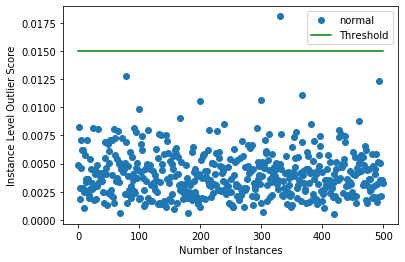

In [11]:
target = np.zeros(X.shape[0],).astype(int)  # all normal CIFAR10 training instances
labels = ['normal', 'outlier']
plot_instance_outlier(od_preds, target, labels, od.threshold)

### Visualize outliers

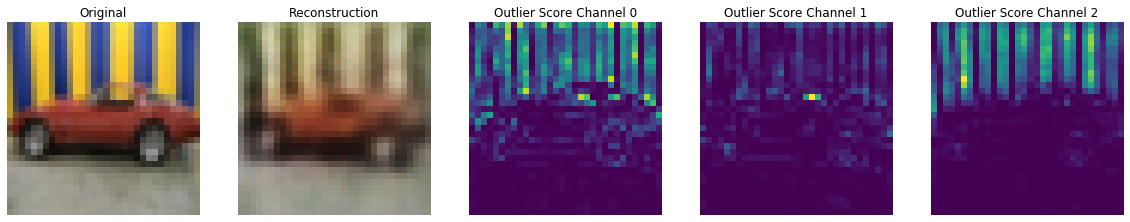

In [12]:
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds, X, X_recon, outliers_only=True, max_outliers=5)

## Predict outliers on perturbed CIFAR images

For each mask size in `n_mask_sizes`, sample `n_masks` and apply those to each of the `n_imgs` images. Then we predict outliers on the masked instances: 

In [13]:
n_mask_sizes = 10
n_masks = 20
n_imgs = 50

Define masks and get images:

In [14]:
mask_sizes = [(2*n,2*n) for n in range(1,n_mask_sizes+1)]
print(mask_sizes)
img_ids = np.arange(n_imgs)
X_orig = X[img_ids].reshape(img_ids.shape[0], 32, 32, 3)
print(X_orig.shape)

[(2, 2), (4, 4), (6, 6), (8, 8), (10, 10), (12, 12), (14, 14), (16, 16), (18, 18), (20, 20)]
(50, 32, 32, 3)


Calculate instance level outlier scores:

In [15]:
all_img_scores = []
for i in tqdm(range(X_orig.shape[0])):
    img_scores = np.zeros((len(mask_sizes),))
    for j, mask_size in enumerate(mask_sizes):
        # create masked instances
        X_mask, mask = apply_mask(X_orig[i].reshape(1, 32, 32, 3),
                                  mask_size=mask_size,
                                  n_masks=n_masks,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))
        # predict outliers
        od_preds_mask = od.predict(X_mask)
        score = od_preds_mask['data']['instance_score']
        # store average score over `n_masks` for a given mask size
        img_scores[j] = np.mean(score)
    all_img_scores.append(img_scores)

  0%|          | 0/50 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


### Visualize outlier scores vs. mask sizes

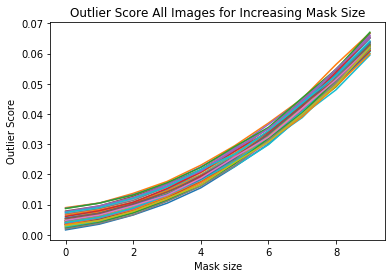

In [16]:
for ais in all_img_scores:
    plt.plot(ais)
plt.title('Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier Score')
plt.show()

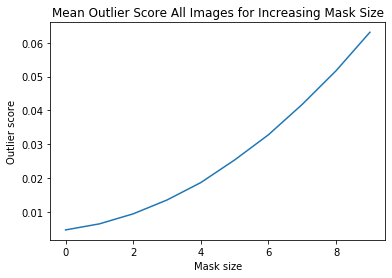

In [17]:
ais_np = np.zeros((len(all_img_scores), all_img_scores[0].shape[0]))
for i, ais in enumerate(all_img_scores):
    ais_np[i, :] = ais
ais_mean = np.mean(ais_np, axis=0)
plt.title('Mean Outlier Score All Images for Increasing Mask Size')
plt.xlabel('Mask size')
plt.ylabel('Outlier score')
plt.plot(ais_mean)
plt.show()

### Investigate instance level outlier

In [18]:
i = 8  # index of instance to look at

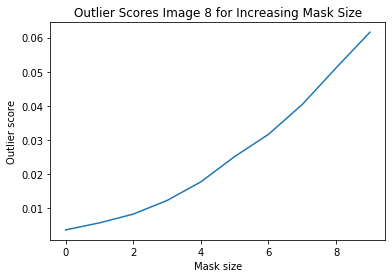

In [19]:
plt.plot(all_img_scores[i])
plt.title('Outlier Scores Image {} for Increasing Mask Size'.format(i))
plt.xlabel('Mask size')
plt.ylabel('Outlier score')
plt.show()

Reconstruction of masked images and outlier scores per channel:

In [20]:
all_X_recon = []
all_X_mask = []
od_preds = {'data': {'is_outlier': [],
                     'feature_score': [],
                     'instance_score': []}}

# reconstruction and score using the original instance
X_i = X_orig[i].reshape(1, 32, 32, 3)
X_recon_i = od.vae(X_i).numpy()
od_preds_i = od.predict(X_i)
is_outlier = od_preds_i['data']['is_outlier'][0]
instance_score = od_preds_i['data']['instance_score'][0]
feature_score = od_preds_i['data']['feature_score'][0]

# store
od_preds['data']['is_outlier'].append(is_outlier)
od_preds['data']['feature_score'].append(feature_score)
od_preds['data']['instance_score'].append(instance_score)
all_X_recon.append(X_recon_i)
all_X_mask.append(X_i)

# apply masks
for j, mask_size in enumerate(mask_sizes):
    # create masked instances
    X_mask, mask = apply_mask(X_i,
                              mask_size=mask_size,
                              n_masks=1,  # just 1 for visualization purposes
                              channels=[0,1,2],
                              mask_type='normal',
                              noise_distr=(0,1),
                              clip_rng=(0,1))
    # reconstruction of masked instance
    X_recon_i = od.vae(X_mask).numpy()
    # predict outliers
    od_preds_i = od.predict(X_mask)
    is_outlier = od_preds_i['data']['is_outlier'][0]
    instance_score = od_preds_i['data']['instance_score'][0]
    feature_score = od_preds_i['data']['feature_score'][0]
    # store
    od_preds['data']['is_outlier'].append(is_outlier)
    od_preds['data']['feature_score'].append(feature_score)
    od_preds['data']['instance_score'].append(instance_score)    
    all_X_recon.append(X_recon_i)
    all_X_mask.append(X_mask)
all_X_recon = np.concatenate(all_X_recon, axis=0)
all_X_mask = np.concatenate(all_X_mask, axis=0)

Visualize:

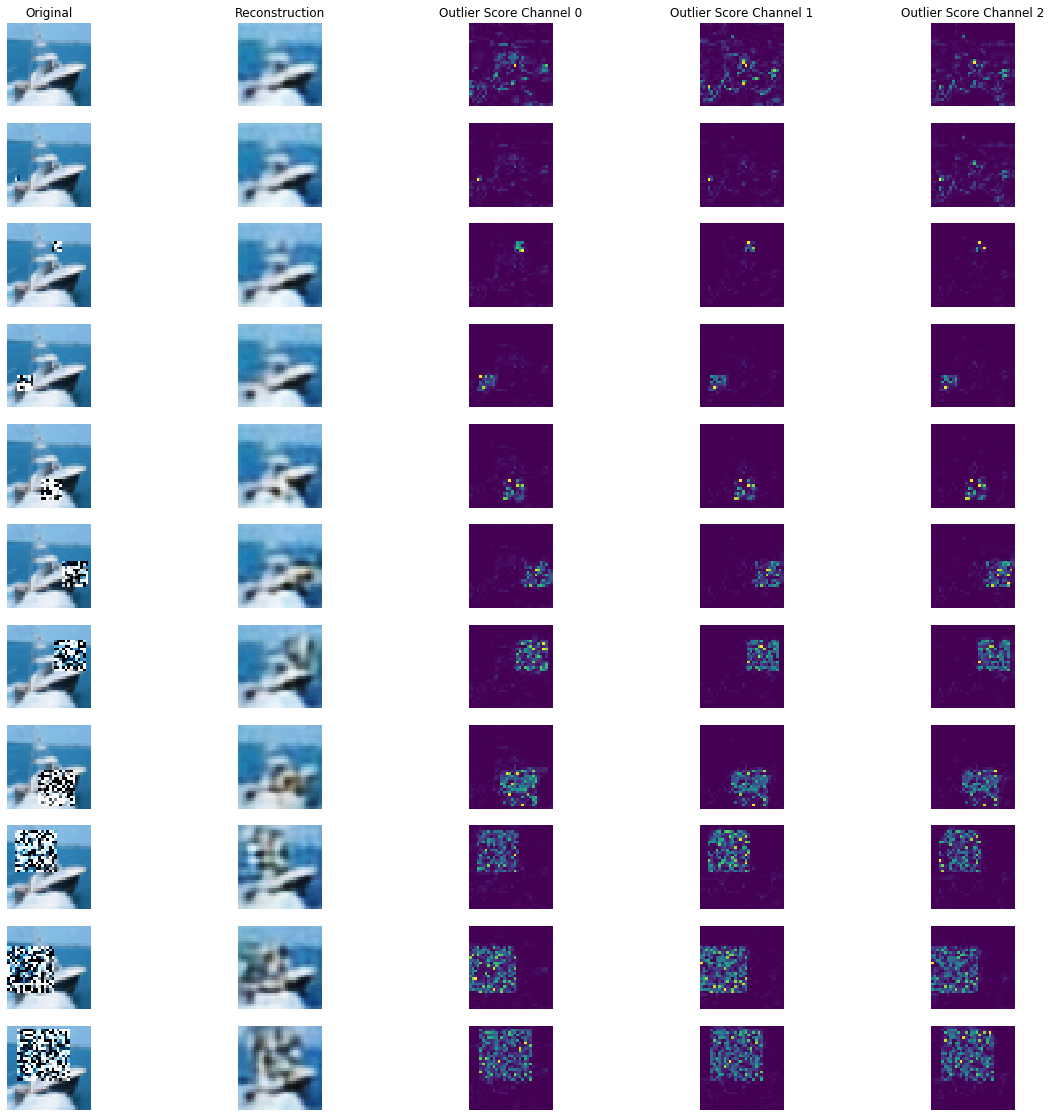

In [21]:
plot_feature_outlier_image(od_preds, 
                           all_X_mask, 
                           X_recon=all_X_recon, 
                           max_outliers=all_X_mask.shape[0], 
                           n_channels=3)